In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import matplotlib.cm as col
import warnings
warnings.filterwarnings("ignore")

# General Settings

In [3]:
max_err=0.2

S = 20000
B = 312858

plt.rcParams['pgf.rcfonts'] = False
plt.rcParams['font.serif'] = []
#plt.rcParams['text.usetex'] = True
#plt.rcParams['figure.figsize'] = 3.5, 2.625
plt.rcParams['axes.formatter.useoffset'] = False
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['errorbar.capsize'] = 2
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.title_fontsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['legend.frameon'] = False
#plt.rcParams['lines.dashed_pattern'] = (1, 3)

In [4]:
colormap_normal = col.get_cmap("viridis")
col_bas = "black"

col_bas_sup = "b"
col_ex1 = "r"
col_ex2 = "orange"
col_ex3 = "dodgerblue"
col_ks = "purple"

# SIC curves

In [5]:
colormap_gaussian = col.get_cmap("viridis")
colormap = col.get_cmap("viridis")
N=6
col_1G = 1/N
col_2G = 2/N
col_5G = 3/N
col_10G = 4/N
col_30G = 5/N
col_50G = 6/N

colormap_2D = "viridis"
global_xaxis = True

NN_runs="50"

## Functions

### Plot visual

In [11]:
def plot_start():
	plt.figure()
	#plt.grid()

def plot_end(name, ylim = None, set_xaxis = None, title=None, background=False): 
	plt.legend()
	
	if set_xaxis is None:
		set_xaxis = global_xaxis

	if set_xaxis:
		if background:
			plt.xlim(5e-5, 1)
		else:
			plt.xlim(0,1)#(-0.05,1.05)
	if ylim is not None:
		plt.ylim(0, ylim)
	
	if background:
		plt.xscale("log")

	if title is not None:
		ymin, ymax = plt.ylim()
		xmin, xmax = plt.xlim()
		a = 0.03
		if background:
			plt.text(np.exp(np.log(xmin) + a * (np.log(xmax)-np.log(xmin))), ymin + (1-a) * (ymax-ymin) , title, size=plt.rcParams['axes.labelsize'], color='black', horizontalalignment='left', verticalalignment='top')
		else:
			plt.text(xmin + a * (xmax-xmin), ymin + (1-a) *(ymax-ymin) , title, size=plt.rcParams['axes.labelsize'], color='black', horizontalalignment='left', verticalalignment='top')
	plt.ylabel(r"$\epsilon_S/\sqrt{\epsilon_B}$")
	plt.xlabel(r"$\epsilon_S$")
	plt.legend()
	plt.savefig("../plots/SICs/sic_"+name+".pdf")
	#print(plt.axis())
	plt.show()

### Plotting

In [7]:
def mean_and_percentiles(x_arrays,y_arrays,number=1000):
	x_values = np.linspace(0.01,1,number)
	y_values = np.zeros((len(y_arrays),len(x_values)))
	for j in range(len(y_arrays)):	
		y_values[j] = interp1d(x_arrays[j], y_arrays[j])(x_values)
	py = 1/y_values	
	y_mean = np.median(py,axis=0)
	#inds = np.argwhere(1/(x_values*S)+y_mean/B/4<0.2**2)[:,0]
	inds = np.argwhere(y_mean < 312858*max_err**2)[:,0]
	y_max = np.percentile(py,84,axis=0) 
	y_min = np.percentile(py,16,axis=0)
	return x_values[inds], y_mean[inds], y_min[inds], y_max[inds]

def plot_fn(tpr,fpr,color,label, linestyle, background=False, alpha=0.2):
    tpr_mean, fpr_mean, fpr_min, fpr_max= mean_and_percentiles(tpr,fpr)
    if not background:
        plt.plot(tpr_mean, tpr_mean*np.sqrt(fpr_mean), color=color,label=label, linestyle=linestyle)
        plt.fill_between(tpr_mean, tpr_mean*np.sqrt(fpr_min), tpr_mean*np.sqrt(fpr_max), alpha=alpha, facecolor=color)
    else:
        plt.plot(1/fpr_mean, tpr_mean/np.sqrt(1/fpr_mean), color=color,label=label, linestyle=linestyle)
        plt.fill_between(1/fpr_mean, tpr_mean/np.sqrt(1/fpr_min), tpr_mean/np.sqrt(1/fpr_max), alpha=alpha, facecolor=color)		
    return 

def import_and_plot(path, label=None, color="grey", folder="rocs/", N_runs =10, start_runs =0, alpha=0.2, linestyle='solid', background=False):	
	#if label is None: 
	#	label=path
	fpr=np.load(folder+"fpr_"+path+".npy")[start_runs:start_runs+N_runs]
	print(fpr.shape)
	#print(fpr.shape)
	tpr=np.load(folder+"tpr_"+path+".npy")[start_runs:start_runs+N_runs]
	plot_fn(tpr,fpr,color,label, linestyle, alpha=alpha, background=background)
	return tpr,fpr

def import_and_plot_all(path, label=None, color="grey", folder="rocs/", N_runs =20, start_runs =0, alpha=0.2):	
	#if label is None: 
	#	label=path
	fpr=np.load(folder+"fpr_"+path+".npy")[start_runs:start_runs+N_runs]
	tpr=np.load(folder+"tpr_"+path+".npy")[start_runs:start_runs+N_runs]
	for i in range(len(tpr)):
		inds = np.argwhere(1/fpr[i] < 312858*max_err**2)[:,0]
		if i==0:
			plt.plot(tpr[i, inds],tpr[i, inds]/np.sqrt(fpr[i, inds]),color=color, alpha=alpha, label=label)
		else:
			plt.plot(tpr[i,inds],tpr[i,inds]/np.sqrt(fpr[i,inds]),color=color, alpha=alpha)
	return tpr,fpr

In [8]:
def mean_and_percentiles_sys(x_arrays,y_arrays, tpr_s, fpr_s, number=1000):
	x_values = np.linspace(0.01,1,number)
	y_values = np.zeros((len(y_arrays),len(x_values)))
	fpr_s_values = np.zeros((len(fpr_s),len(x_values)))
	for j in range(len(y_arrays)):	
		y_values[j] = interp1d(x_arrays[j], y_arrays[j])(x_values)
	py = y_values
	y_mean = np.median(py,axis=0)
	for j in range(len(fpr_s)):
		fpr_s_values[j]=interp1d(fpr_s[j], tpr_s[j])(y_mean)
	eps_f_median = np.median(fpr_s_values, axis=0)
	inds = np.argwhere(y_mean > 1/(312858*max_err**2))[:,0]
	y_max = 1/np.percentile(1/py,84,axis=0) 
	y_min = 1/np.percentile(1/py,16,axis=0)
	return x_values[inds], y_mean[inds], y_min[inds], y_max[inds], eps_f_median[inds]

def sys_func(tpr, fpr, eps_f, N_SR=120000, N_S=772):
	return (tpr+fpr*N_SR/N_S-eps_f*N_SR/N_S)/np.sqrt(fpr)

def plot_fn_sys(tpr,fpr, tpr_s, fpr_s, color,label, linestyle, background=False, alpha=0.2):
	tpr_mean, fpr_mean, fpr_min, fpr_max, eps_f = mean_and_percentiles_sys(tpr,fpr, tpr_s, fpr_s)
	if not background:
		plt.plot(tpr_mean, sys_func(tpr_mean, fpr_mean, eps_f), color=color,label=label, linestyle=linestyle)
		plt.fill_between(tpr_mean, sys_func(tpr_mean, fpr_min, eps_f), sys_func(tpr_mean, fpr_max, eps_f), alpha=alpha, facecolor=color)
	else:
		plt.plot(fpr_mean, sys_func(tpr_mean, fpr_mean, eps_f), color=color,label=label, linestyle=linestyle)
		plt.fill_between(fpr_mean, sys_func(tpr_mean, fpr_min, eps_f), sys_func(tpr_mean, fpr_max, eps_f), alpha=alpha, facecolor=color)
	return 

def import_and_plot_sys(path1="roc_classifier_averaging", path2="roc_classifier_averaging", label=None, color="grey", folder1="rocs/", folder2="rocs/", N_runs =10, start_runs =0, alpha=0.2, linestyle='solid', background=False):	
	#if label is None: 
	#	label=path
	fpr = np.load(folder1+"fpr_"+path1+".npy")[start_runs:start_runs+N_runs]
	fpr_s = np.load(folder2+"fpr_"+path2+".npy")[start_runs:start_runs+N_runs]
	print(fpr_s.shape)
	tpr=np.load(folder1+"tpr_"+path1+".npy")[start_runs:start_runs+N_runs]
	tpr_s = np.load(folder2+"tpr_"+path2+".npy")[start_runs:start_runs+N_runs]
	plot_fn_sys(tpr,fpr, tpr_s, fpr_s, color,label, linestyle, alpha=alpha, background=background)
	return tpr,fpr

## Plots

(4, 19359)
(4, 26190)
(4, 21579)
(4, 36378)


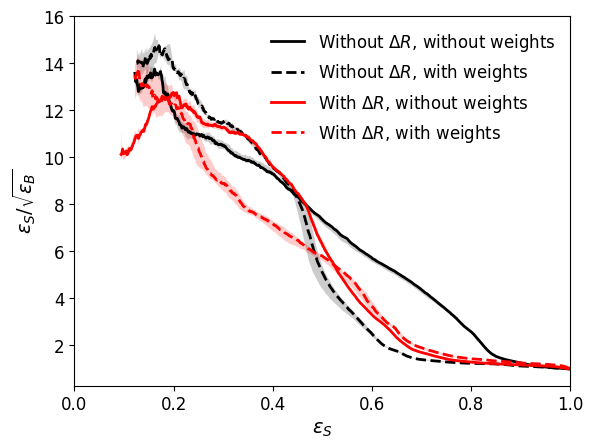

In [30]:
plot_start()
import_and_plot("roc_classifier_averaging", label=r"Without $\Delta R$, without weights",color=col_bas, folder="/hpcwork/zu992399/bumphunt_paper/DE/scan_norm_2_15_256/window5/cathode/")
import_and_plot("roc_classifier_averaging", label=r"Without $\Delta R$, with weights",color=col_bas, linestyle="dashed", folder="/hpcwork/zu992399/bumphunt_paper/DE/scan_norm_2_15_256/window5/cathode_weights/")
import_and_plot("roc_classifier_averaging", label=r"With $\Delta R$, without weights",color=col_ex1, folder="/hpcwork/zu992399/bumphunt_paper/DE/scan_norm_DR_2_15_256/window5/cathode/")
import_and_plot("roc_classifier_averaging",color=col_ex1, label =r"With $\Delta R$, with weights", linestyle="dashed", folder="/hpcwork/zu992399/bumphunt_paper/DE/scan_norm_DR_2_15_256/window5/cathode_weights/")
name = "doctor_CATHODE"
plot_end(name, set_xaxis=True)

# ROC curves

In [11]:
def plot_end_ROC(name, ylim = None, set_xaxis = None, title=None, doublelog=False, ncol=1): 
    plt.legend()
	
    if set_xaxis is None:
        set_xaxis = global_xaxis
	
    plt.yscale("log")
    if doublelog:
        plt.xscale("log")

    if set_xaxis:
        plt.xlim(0,1)#(-0.05,1.05)
    plt.ylim(1e-3, ylim)

    if title is not None:
        ymin, ymax = plt.ylim()
        xmin, xmax = plt.xlim()
        a = 0.03
        plt.text(xmin + a * (xmax-xmin), ymin + (1-a) *(ymax-ymin) , title, size=plt.rcParams['axes.labelsize'], color='black', horizontalalignment='left', verticalalignment='top')
    plt.ylabel(r"$1/FPR-1/TPR$")
    plt.xlabel(r"$TPR$")
    plt.legend(ncol=ncol)
    plt.savefig("plots/roc_"+name+".pdf")
    #print(plt.axis())
    plt.show()

In [12]:
def plot_fn_ROC(tpr,fpr,color,label, linestyle, background=False, alpha=0.2):
    tpr_mean, fpr_mean, fpr_min, fpr_max= mean_and_percentiles(tpr,fpr)
    plt.plot(tpr_mean, fpr_mean-1/tpr_mean, color=color,label=label, linestyle=linestyle)
    plt.fill_between(tpr_mean, fpr_min-1/tpr_mean, fpr_max-1/tpr_mean, alpha=alpha, facecolor=color)
    return 

def import_and_plot_ROC(path, label=None, color="grey", folder="rocs/", N_runs =10, start_runs =0, alpha=0.2, linestyle='solid', AUC=False):	
	#if label is None: 
	#	label=path
	fpr=np.load(folder+"fpr_"+path+".npy")[start_runs:start_runs+N_runs]
	#print(fpr.shape)
	tpr=np.load(folder+"tpr_"+path+".npy")[start_runs:start_runs+N_runs]
	if AUC:
		auc = np.load(folder+"auc_"+path+".npy")[start_runs:start_runs+N_runs]
		if label is None:
			label = "AUC="+str(np.round(np.mean(auc),decimals=3))
		else:
			label+= ", AUC="+str(np.round(np.mean(auc),decimals=3))
	plot_fn_ROC(tpr,fpr,color,label, linestyle, alpha=alpha)
	return tpr,fpr

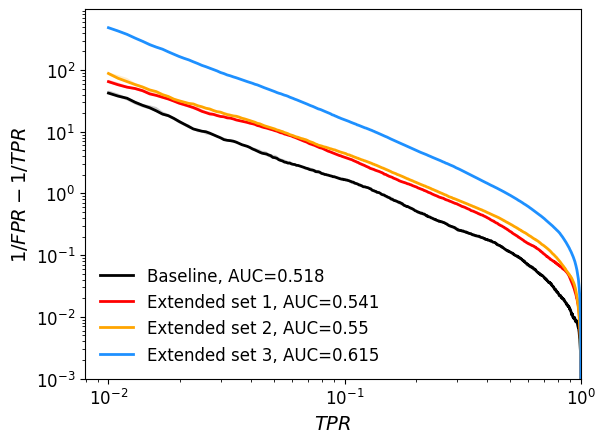

In [13]:
plot_start()
import_and_plot_ROC("roc_classifier_averaging", label="Baseline", AUC=True,color=col_bas, folder="/home/zu992399/PhD/testing/results/sample_test_baseline_BDT/")
import_and_plot_ROC("roc_classifier_averaging", label="Extended set 1", AUC=True,color=col_ex1,folder="/home/zu992399/PhD/testing/results/sample_test_extended1_BDT/")
import_and_plot_ROC("roc_classifier_averaging", label="Extended set 2", AUC=True,color=col_ex2, folder="/home/zu992399/PhD/testing/results/sample_test_extended2_BDT/")
import_and_plot_ROC("roc_classifier_averaging", label="Extended set 3", AUC=True,color=col_ex3, folder="/home/zu992399/PhD/testing/results/sample_test_extended3_BDT/")
name = "CATHODE_samples_bkg"
plot_end_ROC(name, set_xaxis=True, doublelog=True)

# 1D plot

In [32]:
def read_ROC_SIC_1D(path, points, folder, N_runs=10, start_runs=0):
	fpr=np.load(folder+"fpr_"+path+".npy")[start_runs:start_runs+N_runs]
	print(fpr.shape)
	tpr=np.load(folder+"tpr_"+path+".npy")[start_runs:start_runs+N_runs]
	ROC_values = np.zeros((len(fpr),len(points)))
	SIC_values = np.zeros((len(fpr),len(points)+2))
	for j in range(len(ROC_values)):
		inds = np.nonzero(tpr[j])[0]
		t = tpr[j, inds]
		f = fpr[j, inds]
		ROC_values[j] = interp1d(f, 1/f)(points)
		SIC_values[j,:-2] = interp1d(f, t/np.sqrt(f))(points)
		SIC_values[j,-1] = np.nanmax(np.nan_to_num(t/np.sqrt(f), posinf=0),where= f>1/312858/max_err**2,initial=0)
		SIC_values[j,-2] = np.nanmax(np.nan_to_num(t/np.sqrt(f),posinf=0))
	return np.median(SIC_values,axis=0), np.percentile(SIC_values, 16, axis=0), np.percentile(SIC_values, 84, axis=0)

def plot_end_1D(sig, name, small=True): 

	plt.legend()
	plt.ylabel(r"$\max\ \epsilon_S/\sqrt{\epsilon_B}$")
	plt.xlabel(r"$N_{sig}$")
	plt.xticks(sig)
	plt.savefig("plots/1D_"+name+".pdf")
	plt.show()

def plot_sic(sic, sic_low, sic_upp, sig, color, label, normed=False, linestyle="solid"):
	if normed:
		n = np.max(sic)
		plt.plot(sig, sic/n, color=color,label=label, linestyle=linestyle)
		plt.fill_between(sig, sic_low/n, sic_upp/n, alpha=0.2, facecolor=color)
		return
	plt.plot(sig, sic, color=color,label=label, linestyle=linestyle)
	plt.fill_between(sig, sic_low, sic_upp, alpha=0.2, facecolor=color)

In [33]:
points = np.array([0.1,0.01])

directory = "/hpcwork/zu992399/1D_Nsig/"
directory2 = "/work/zu992399/BackToTheRoots/1D_Nsig/"

sig = np.array([0, 100, 200, 300, 400, 500, 750, 1000, 1200, 1500, 2000])#, 2500, 3000])
sig_plot = np.array([0,500,1000,1500, 2000])#, 2500, 3000])

sic = np.zeros((len(sig),len(points)+2))
sic_low = np.zeros((len(sig),len(points)+2))
sic_upp = np.zeros((len(sig),len(points)+2))

plt.figure()
for j,s in enumerate(sig):
	sic[j], sic_low[j], sic_upp[j] = read_ROC_SIC_1D("roc_classifier_averaging", points, directory2+"baseline/Nsig_"+str(s)+"/")
plot_sic(sic[:,-1], sic_low[:,-1], sic_upp[:,-1], sig, col_bas, "Baseline")

for j,s in enumerate(sig):
	sic[j], sic_low[j], sic_upp[j] = read_ROC_SIC_1D("roc_classifier_averaging", points, directory2+"cathode_baseline/Nsig_"+str(s)+"/")
plot_sic(sic[:,-1], sic_low[:,-1], sic_upp[:,-1], sig, col_bas, linestyle="dashdot", label="Baseline CATHODE")

for j,s in enumerate(sig):
	sic[j], sic_low[j], sic_upp[j] = read_ROC_SIC_1D("roc_classifier_averaging", points, directory2+"cwola_baseline/Nsig_"+str(s)+"/")
plot_sic(sic[:,-1], sic_low[:,-1], sic_upp[:,-1], sig, col_bas, linestyle="dotted", label="Baseline CWoLa")

sic_all = np.zeros((len(sig),len(points)+2))
sic_all_low = np.zeros((len(sig),len(points)+2))
sic_all_upp = np.zeros((len(sig),len(points)+2))
for j,s in enumerate(sig):
	sic_all[j], sic_all_low[j], sic_all_upp[j] = read_ROC_SIC_1D("roc_classifier_averaging", points, directory2+"extended3/Nsig_"+str(s)+"/")
plot_sic(sic_all[:,-1], sic_all_low[:,-1], sic_all_upp[:,-1], sig, col_ex3, "Extended set 3")

for j,s in enumerate(sig):
	sic_all[j], sic_all_low[j], sic_all_upp[j] = read_ROC_SIC_1D("roc_classifier_averaging", points, directory2+"cathode_extended3/Nsig_"+str(s)+"/")
plot_sic(sic_all[:,-1], sic_all_low[:,-1], sic_all_upp[:,-1], sig, col_ex3, linestyle="dashdot", label=None)


for j,s in enumerate(sig):
	sic_all[j], sic_all_low[j], sic_all_upp[j] = read_ROC_SIC_1D("roc_classifier_averaging", points, directory2+"cwola_extended3/Nsig_"+str(s)+"/")
plot_sic(sic_all[:,-1], sic_all_low[:,-1], sic_all_upp[:,-1], sig, col_ex3, linestyle="dotted", label=None)

plot_end_1D(sig_plot, "CWoLa_CATHODE_max_err")

FileNotFoundError: [Errno 2] No such file or directory: '/work/zu992399/BackToTheRoots/1D_Nsig/baseline/Nsig_0/fpr_roc_classifier_averaging.npy'

<Figure size 640x480 with 0 Axes>